In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

In [2]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2

  Created wheel for colabgymrender: filename=colabgymrender-1.0.2-py3-none-any.whl size=2444 sha256=bf6b4cb33bf8923e4e975a5888261a648a1ba21541d27de590a70f5189eb863a
  Stored in directory: /root/.cache/pip/wheels/1f/56/73/3697080da5fc7b120516aef37d1d1eb2380515ba9e272b8ccd
Successfully built colabgymrender


In [3]:
from colabgymrender.recorder import Recorder

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2514944/45929032 bytes (5.5%)5251072/45929032 bytes (11.4%)7929856/45929032 bytes (17.3%)10797056/45929032 bytes (23.5%)13565952/45929032 bytes (29.5%)16580608/45929032 bytes (36.1%)19529728/45929032 bytes (42.5%)22478848/45929032 bytes (48.9%)25403392/45929032 bytes (55.3%)28319744/45929032 bytes (61.7%)30998528/45929032 bytes (67.5%)33792000/45929032 bytes (73.6%)

In [4]:
env = gym.make('CartPole-v0')
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0

while not done:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state

print(total_reward)
env.play()


19.0


100%|██████████| 21/21 [00:00<00:00, 249.91it/s]


In [5]:
total_reward

19.0

In [6]:
# Hyperparameters
max_epsilon = 1.0
min_epsilon = 0.01
max_num_steps = 50000
epsilon_decay_intervals = 10000
gamma = 0.99 # discount
alpha = 5e-4 # learning rate

memory_size = 50000
min_replay_size = 1000
batch_size = 32

target_update_frequency = 1000 # target network update frequency

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self, env):
        super(NeuralNetwork, self).__init__()
    
        self.network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 64),
            #nn.ReLU(),
            nn.Tanh(),
            nn.Linear(64, env.action_space.n)
        )
    
    def forward(self, state):
        return self.network(state)
    
    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

In [8]:
def fill_memory(env):
    memory = deque(maxlen=memory_size)
    state = env.reset()
    for _ in range(min_replay_size):
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        state = next_state
        if done:
            env.reset()
    
    return memory

In [9]:
def dqn_training(env, max_num_steps, max_epsilon, min_epsilon, num_epsilon_decay_intervals, gamma, lr):
    q_net = NeuralNetwork(env)
    target_net = NeuralNetwork(env)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = torch.optim.Adam(q_net.parameters(), lr=lr)

    memory = fill_memory(env)
    reward_buffer = deque(maxlen=100) # Rewards of the previous 100 episodes

    reward_per_episode = 0.0
    state = env.reset()
    all_rewards = []
    for step in range(max_num_steps):
        epsilon = np.interp(step, [0, num_epsilon_decay_intervals], [max_epsilon, min_epsilon])

        random_number = np.random.uniform(0,1)
        if random_number <= epsilon:
            action = env.action_space.sample()
        else:
            action = q_net.choose_action(state)
        
        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        reward_per_episode += reward

        state = next_state

        if done:
            state = env.reset()
            reward_buffer.append(reward_per_episode)
            all_rewards.append((step, reward_per_episode))
            reward_per_episode = 0.0

        
        # Take a batch of experiences from the memory
        experiences = random.sample(memory, batch_size)
        states = [ex[0] for ex in experiences]
        actions = [ex[1] for ex in experiences]
        rewards = [ex[2] for ex in experiences]
        dones = [ex[3] for ex in experiences]
        next_states = [ex[4] for ex in experiences]

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(-1)
        next_states = torch.tensor(next_states, dtype=torch.float32)

        # Compute targets using the formulation sample = r + gamma * max q(s',a')
        target_q_values = target_net(next_states)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        targets = rewards + gamma * (1-dones) * max_target_q_values

        # Compute loss
        q_values = q_net(states)

        action_q_values = torch.gather(input=q_values, dim=1, index=actions)
        loss = torch.nn.functional.mse_loss(action_q_values, targets)

        # gradient descent for q-network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update target network
        if (step+1) % target_update_frequency == 0:
            target_net.load_state_dict(q_net.state_dict())

        # print training results
        if (step+1) % 1000 == 0:
            average_reward = np.mean(reward_buffer)
            print(f'Episode: {len(all_rewards)} Step: {step+1} Average reward: {average_reward}')

    return all_rewards, q_net

In [10]:
all_rewards, q_net = dqn_training(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr=alpha)

Episode: 45 Step: 1000 Average reward: 22.22222222222222
Episode: 94 Step: 2000 Average reward: 21.159574468085108
Episode: 145 Step: 3000 Average reward: 20.0
Episode: 191 Step: 4000 Average reward: 20.57
Episode: 226 Step: 5000 Average reward: 23.67
Episode: 258 Step: 6000 Average reward: 27.0
Episode: 281 Step: 7000 Average reward: 31.9
Episode: 305 Step: 8000 Average reward: 35.87
Episode: 323 Step: 9000 Average reward: 40.41
Episode: 335 Step: 10000 Average reward: 47.11
Episode: 342 Step: 11000 Average reward: 54.38
Episode: 349 Step: 12000 Average reward: 63.3
Episode: 354 Step: 13000 Average reward: 70.1
Episode: 359 Step: 14000 Average reward: 78.01
Episode: 364 Step: 15000 Average reward: 85.02
Episode: 369 Step: 16000 Average reward: 93.53
Episode: 374 Step: 17000 Average reward: 101.9
Episode: 379 Step: 18000 Average reward: 109.51
Episode: 384 Step: 19000 Average reward: 117.36
Episode: 389 Step: 20000 Average reward: 125.33
Episode: 394 Step: 21000 Average reward: 133.29


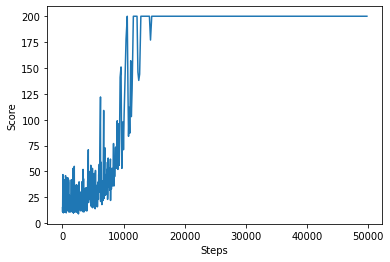

In [11]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

In [12]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()

with torch.no_grad():
    while not done:
        #action = env.action_space.sample()
        action = q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

200.0


100%|█████████▉| 201/202 [00:00<00:00, 278.53it/s]
